# CAT & DOG CLASSIFIER
## Via Transfer Learning

### Importing The Libraries

    For this model we will be using the tensorflow library.

In [15]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from PIL import Image

### Loading Data
    The Data for training and testing the model was provided and downloaded from : 'https://docs.google.com/document/d/1LkldAXWsn_7fBq8R4yR0rFjK_1sShgyewlawJ8KOuMU/edit'. Here we use the numpy library to load the model as it is in the .npy format.

In [19]:
# Defining pics
img_train = np.load(r'C:\Users\Hp\Downloads\images_train.npy')
label_train = np.load(r'C:\Users\Hp\Downloads\labels_train.npy')
img_valid = np.load(r'C:\Users\Hp\Downloads\images_valid.npy')
label_valid = np.load(r'C:\Users\Hp\Downloads\labels_valid.npy')
img_test = np.load(r'C:\Users\Hp\Downloads\images_test.npy')
label_test = np.load(r'C:\Users\Hp\Downloads\labels_test.npy')

print(img_train.shape, img_valid.shape, img_test.shape)

(600, 160, 160, 3) (300, 160, 160, 3) (300, 160, 160, 3)


### Transfer Model
    Here we are using the Mobilenet.V2 model as our transfer model. Download the model from : 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'. And then specify the path of the downloaded model in order to call it. 

In [17]:
# Using mobilenet_v2 model for Transfer Learning
#https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
transfer_model = 'D:\DL Model\MobilenetV2'
pretrained_model = hub.KerasLayer(transfer_model, input_shape=(224, 224, 3), trainable=False)

### Re-Sizing Input Images
    For the mobilenet.V2 model, input image should be of size 224x224, our input is of size 160x160. Hence, we need to re-size our input images to the appropriate size. For this purpose we have defined the resize function. Keep in mind to convert the output back into a numpy array in the end.
    

In [20]:
#for re-sizing as model only accepts 224 x 224 images
def resize(im, nR, nC):
    
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
        for c in range(nC)] for r in range(nR)]

In [21]:
x_train = np.zeros((600,224,224,3))
for i in range(len(img_test)):
    x_train[i] = resize(img_train[i], 224, 224)
    x_train[i] = np.array(x_train[i])
    
x_valid = np.zeros((300,224,224,3))
for i in range(len(img_test)):
    x_valid[i] = resize(img_valid[i], 224, 224)
    x_valid[i] = np.array(x_valid[i])
    
x_test = np.zeros((300,224,224,3))
for i in range(len(img_test)):
    x_test[i] = resize(img_test[i], 224, 224)
    x_test[i] = np.array(x_test[i])

### Normalization
    We divide the input by 255. This increases the accuracy of the model and it converges faster. As we have reduced the range from 0 & 255 to 0 & 1

In [22]:
# Image re-scaling bw 0 & 1
img_train_scaled = x_train/255
img_valid_scaled = x_valid/255
img_test_scaled = x_test/255

### Adding Layer
    We add a single dense layer to the model with two outputs.

In [23]:
num_classes = 2
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Next we define the optimizer, loss and the accuracy.

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

### Training

In [25]:
model.fit(img_train_scaled, label_train, batch_size=6, epochs=4)

Epoch 1/4
100/100 [==============================] - 28s 184ms/step - loss: 0.5363 - acc: 0.6817
Epoch 2/4
100/100 [==============================] - 18s 176ms/step - loss: 0.4355 - acc: 0.7117
Epoch 3/4
100/100 [==============================] - 19s 185ms/step - loss: 0.4011 - acc: 0.7283
Epoch 4/4
100/100 [==============================] - 17s 170ms/step - loss: 0.3831 - acc: 0.7533


In [26]:
model.fit(img_valid_scaled, label_valid, batch_size=3, epochs=2)

Epoch 1/2
100/100 [==============================] - 10s 90ms/step - loss: 0.1309 - acc: 0.9467
Epoch 2/2
100/100 [==============================] - 9s 90ms/step - loss: 0.0573 - acc: 0.9767


### Evaluation

In [27]:
score, acc = model.evaluate(img_test_scaled, label_test)
print('Test set loss:', score)
print('Test set accuracy:', acc)

10/10 [==============================] - 9s 811ms/step - loss: 0.1214 - acc: 0.9533
Test set loss: 0.12137126922607422
Test set accuracy: 0.95333331823349


### Manually Checking
    The function given below is for manually checking a model on a given picture downloaded on your device. e.g. D:\Pics\P1.jpg.

In [35]:
def check():
    input_image_path = input('')
    input_image = cv2.imread(input_image_path)
    Image.open(input_image_path)
    input_image_resize = cv2.resize(input_image, (224, 224))
    input_image_scaled = input_image_resize/255
    reshaped_image = np.reshape(input_image_scaled, [1,224,224,3])
    pred = model.predict(reshaped_image)
    pred_label = np.argmax(pred)
    if (pred_label == 0):
        print('The Image is of a Dog.')
    if (pred_label == 1):
        print('The Image is of a Cat.')
    return Image.open(input_image_path)

### Saving The Model

In [28]:
model.save('CatDogmodel.h5')

### Loading The Model

In [29]:
reloaded_model = tf.keras.models.load_model(
       ('CatDogmodel.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

 D:\Pics\P5.jpg


1/1 [==============================] - 0s 66ms/step
The Image is of a Dog.


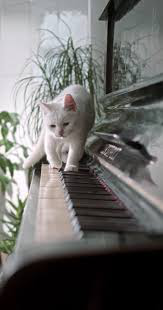

In [36]:
check()